# Stochastic Subspace Identification (SSI)


Largely taken from [1]:

The stochastics of a dynamic system can be described by a state space model with state variables $x_k$ and measured outputs $y_k$ for every timestep $k$:

\begin{equation}
x_{k+1} = A x_k + w_k\\
y_{k} = C x_k + v_k
\end{equation}

The state transition matrix $A$ characterizes a dynamic system with its eigenvectors and eigenvalues.

[1] PEETERS, B. AND G. DE ROECK Stochastic System Identification for Operational Modal Analysis: A Review. Journal of Dynamic Systems, Measurement, and Control,  2001, 123(4), 659-667.


The output covariances $R_i$ are defined as:
\begin{equation}
R_i = E[y_{k-i},y_k^T] = \lim_{N \to \infty}{\frac{1}{N}\sum_{k=0}^{N-1} y_{k-i},y_k^T}
\end{equation}

They can be decomposed as:
$R_i = C A^{i-1} G$

with the next state -- output covariance matix:
$G = E[x_{k+1}, y_k^T]$

A sequence of covariance matrices $R_i$


## Example

In [1]:
# neccesary imports:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from pyomac import ssi_cov, ssi_cov_poles, filter_ssi_single_order, ssi_cov_poles_for_model_order
from pyomac.plot import ssi_stability_plot, fdd_peak_picking_plot

# custom styling for this document
no_spines_dict = {"axes.spines.left":   False,
                  "axes.spines.bottom": False,
                  "axes.spines.top":    False,
                  "axes.spines.right": False}
# The color cycle corresponds to seaborn.color_palette("Blues").as_hex()[1::2]
color_cycler = cycler(color=['#bad6eb', '#539ecd', '#0b559f'])


The data are a timeseries of 18 channels with 90000 samples at a sampling frequency of 100 Hz. Some of this data is shown below.

Note: here we make use of temporary styling the plots with the [matplotlib.style.context](https://matplotlib.org/stable/tutorials/introductory/customizing.html#temporary-styling) context-manager.

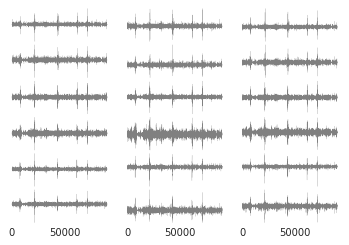

In [2]:
with open('../../examples/sample.csv') as csv_file:
    data = np.loadtxt(csv_file, skiprows=1, delimiter=',')

n_channels = data.shape[1]
n_rows = 6
chan_per_rows = n_channels // n_rows
with plt.style.context([
    "seaborn-white",
    no_spines_dict, 
    {"lines.linewidth":0.15,
    "ytick.left": False,
    "ytick.labelleft": False,
    "axes.prop_cycle": cycler(color=["0.5"]),
    "figure.subplot.hspace": 0.0,
    "figure.subplot.wspace": 0.1},
]):
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=chan_per_rows,
        sharex=True,
        sharey=False,
    )
    for i_c, c in enumerate(data.T):
        axs.flatten()[i_c].plot(c)

The modal properties are estimated with SSI. With `ssi_cov_poles` all model orders up to a specified maximum model order are regarded. The number of block rows for the block Toeplitz matrix has to be greater than the maximum model order.

The modal frequencies, dampings, and shapes are returned as lists with each list element containing the properties of _one_ model order. Thus, these lists are `max_model_order` long.

On a testing machine, one run takes about ~3..5s.

In [3]:
%%timeit
# 5.25s per run
freq, xi, Psi = ssi_cov_poles(data=data, fs=100, n_block_rows=100, max_model_order=50)

3.42 s ± 552 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In the benchmarking-cell the results are not stored in the variables and have to be calculated again:

In [4]:
freq, xi, Psi = ssi_cov_poles(data=data, fs=100, n_block_rows=100, max_model_order=50)

With `ssi_stability_plot` the stability diagram for the modal frequencies can be drawn.

The value on the y-axis is  the parameter of the model order. Modal properties are often also termed _poles_. Poles are regarded as _stable_ if they form columns in the stability diagram, and thus are stable over a range of increasing model orders.

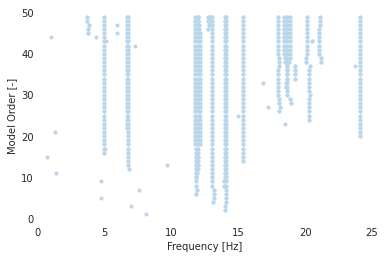

In [5]:
with plt.style.context(
    ["seaborn-white",
    no_spines_dict,
    {"scatter.marker": ".", "axes.prop_cycle": color_cycler}]
):
    fig, ax = ssi_stability_plot(freq)

One approach is to set the model order parameter to a fixed value and then further postprocess the poles of that model order.

<!---
One tool to assist the choice of the right model order is to examine the participation of the eigenvalues of the block Toeplitz matrix. The function `ssi_cov_model_order_participation` yields the normalized cumulative participations of the eigenvalues.
--->

With a model order chosen, `ssi_cov_poles_for_model_order` yields the modal parameters for this specifed model order:

In [6]:
freq_30, xi_30, Psi_30 = ssi_cov_poles_for_model_order(
    data=data,
    fs=100,
    n_block_rows=100,
    model_order=30
)
np.sort(freq_30)

array([ 4.98374357,  4.98374357,  6.71408826,  6.71408826,  6.79404268,
        6.79404268, 11.80318089, 11.80318089, 11.99178066, 11.99178066,
       12.12166609, 12.12166609, 13.06515041, 13.06515041, 13.99169432,
       13.99169432, 14.09597091, 14.09597091, 15.36552681, 15.36552681,
       17.97049904, 17.97049904, 18.65785375, 18.65785375, 20.33200978,
       20.33200978, 24.10498631, 24.10498631, 39.09075306, 39.09075306])

Another approach is to postprocess the sets of poles of all model orders. This is especially relevant in scenarios where the operational modal analysis has to be performed automatically.

These sets of poles contain not so-called _natural_ poles (i.e. Modes of the pysical system) but also so-called _spurious_ or _numerical_ poles which are equivalent to computational noise.
To separate natural from spurious poles, two strategies have been established:

1. Filter poles by plausibility checks and their stability over several model orders. The results of this step are commonly known as _stable_ poles.
2. Cluster poles based on simmilarity metrics. This yields the added benefit of an automatic operational modal analysis.

Usually, clustering is applied to a set of stable poles.
In the following, the procedures are largely taken from [2].

[2] REYNDERS, E., J. HOUBRECHTS AND G. DE ROECK Fully automated (operational) modal analysis. Mechanical Systems and Signal Processing,  2012, 29, 228-250.


The poles of each individual model order can be filtered based on these criteria:

 - Natural poles appear in complex-conjugate pairs. As the SSI-COV algorithm -- as implemented -- only yields _real_ values for frequency and damping instead of _complex_ values, the natural poles occur twice in the set of modal frequencies.
 - The damping has to be positive and in civil structures usually lies below a certain plausible threshold.
 - The mean phase deviation (MPD) of the modeshape is above a certain threshold. (__THIS IS NOT IMPLEMENTED YET__)

For a set of modal properties of a model order, the function `filter_ssi_single_order` yields a boolean mask for the plausible poles, returning only the first of the duplicate natural poles. This is exemplified for model order 21 in our data:

In [7]:
stable_poles_21 = filter_ssi_single_order(freq[20], xi[20], Psi[20])
stable_poles_21

array([ True, False, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False])

The frequencies of the stable poles are:

In [8]:
freq[20][stable_poles_21]

array([24.08708776,  4.98413704,  6.76027173, 15.36479073, 14.09572465,
       13.99085913, 13.0650084 , 12.12620078, 11.9988649 , 11.80363706])

The frequencies of filtered and unfiltered poles can be shown in a stability diagram.

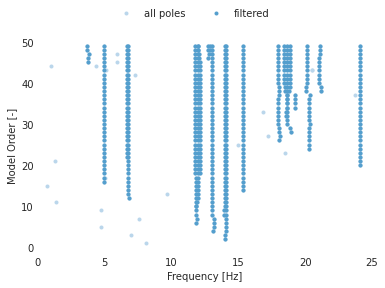

In [9]:
filterd_freqs = [f[filter_ssi_single_order(
    f, x, P)] for f, x, P in zip(freq, xi, Psi)]

with plt.style.context(
    ["seaborn-white",
     no_spines_dict,
     {"scatter.marker": ".", "axes.prop_cycle": color_cycler}]
):
    fig, ax = ssi_stability_plot(freq, label="all poles")
    _, _ = ssi_stability_plot(
        filterd_freqs, fig_obj=(fig, ax), label="filtered")
    fig.legend(loc="upper center", ncol=2, frameon=False)


The discernment of stable poles usually follows criteria for the admissible relative deviation of poles of consecutive model orders. These are for example:

 - The frequencies should not deviate by more than 2%
 - The damping rations should not deviate by more than 5%
 - The modal assurance criterions (MACs) should not be lower than 0.97

These are the default values that are implemented.